In [1]:
import h5py
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import sys
import time
import pandas as pd
import cv2
import os
import imageio
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import shutil
import random

from deepcell.utils.tracking_utils import load_trks

/opt/conda/lib/python3.7/site-packages/tensorflow-2.5.0-py3.7-linux-x86_64.egg/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [2]:
# get well by well, and store
d4 = [180, 710, 160, 690]
d3 = [180, 710, 880, 1410]
d2 = [180, 710, 1600, 2130]
d1 = [180, 710, 2320, 2850]

c4 = [895, 1425, 160, 690]
c3 = [895, 1425, 880, 1410]
c2 = [895, 1425, 1600, 2130]
c1 = [895, 1425, 2320, 2850]

b4 = [1620, 2150, 160, 690]
b3 = [1620, 2150, 880, 1410]
b2 = [1620, 2150, 1600, 2130]
b1 = [1620, 2150, 2320, 2850]

a4 = [2340, 2870, 160, 690]
a3 = [2340, 2870, 880, 1410]
a2 = [2340, 2870, 1600, 2130]
a1 = [2340, 2870, 2320, 2850]

In [3]:
def get_raw_well(well, video_path="../22956814/22956814.mp4", well_name='A4', filename=False, frame_start=0, frame_end=9001, down_sampling=1):    
    print('--------', well_name, '--------')
    frames = []
    
    ymin = well[0]
    ymax = well[1]
    xmin = well[2]
    xmax = well[3]

    #path = "../22956814/22956814.mp4"
    cap = cv2.VideoCapture(video_path)
    ret = True
    while ret:
        ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
        if ret:
            frames.append(img[ymin:ymax, xmin:xmax, :])
    
    stacked = np.stack(frames, axis=0)
    stacked = stacked.astype(dtype='float32')
    stacked_mean = np.mean(stacked, axis=3)[:,:,:,None]
    
    if frame_start != 0 or frame_end != 9001 or down_sampling != 1:
        stacked_mean = stacked_mean[frame_start:(frame_end+1):down_sampling, :, :, :]
    
    if filename:
        output_fn = filename
    else:
        output_fn = 'well_A/raw_%s.npy' % well_name
        
    np.save(output_fn, stacked_mean)
    
    #return stacked_mean

In [6]:
get_raw_well(a1, well_name='A1', filename='../22956814/raw_wells/A1.npy')

-------- A1 --------


In [4]:
# Check available memory

import psutil
psutil.virtual_memory()  # looks good!

svmem(total=439595151360, available=434826682368, percent=1.1, used=1597607936, free=436986372096, active=1158955008, inactive=580882432, buffers=125358080, cached=885813248, shared=9052160, slab=284012544)

In [14]:
# Files to be removed
fn_remove = []

In [15]:
import gc
import os

raw_video = np.load('../22956814/raw_wells/A1.npy')

mask_frame_info_fn = "../22956814/%s_not_empty.txt" % 'A1'
with open(mask_frame_info_fn, 'r') as f:
    start_end_samplings = f.read().splitlines()  # Cool!! 
    for i, each in enumerate(start_end_samplings):
        frame_start, frame_end, down_sampling = each.split(",")
        fn = "../22956814/%s_raw_%d.npy" % ('A1', (i+1))
        
        frame_start = int(frame_start)
        frame_end = int(frame_end)
        down_sampling = int(down_sampling)
        
        raw_array = raw_video[frame_start:frame_end+1:down_sampling, :, :, :]
        print(raw_array.shape)
        
        # IMPORTANT!!
        if raw_array.shape[0] != 100:
            print("HAVE TO REMOVE: ", fn, " and its masked npy!")
            fn_remove.append(fn)
        
        np.save(fn, raw_array)
        
        # Clear the raw_array memory
        del raw_array
        gc.collect()

# At the end, clear raw_video memory
del raw_video
gc.collect()

(100, 530, 530, 1)
(52, 530, 530, 1)
HAVE TO REMOVE:  ../22956814/A1_raw_2.npy  and its masked npy!


0

In [16]:
import psutil
psutil.virtual_memory()  # looks good!

svmem(total=439595151360, available=432070303744, percent=1.7, used=4161957888, free=423449096192, active=13742714880, inactive=1184972800, buffers=60174336, cached=11923922944, shared=9056256, slab=623755264)

In [17]:
# Other wells
get_raw_well(a2, well_name='A2', filename='../22956814/raw_wells/A2.npy')
get_raw_well(a3, well_name='A3', filename='../22956814/raw_wells/A3.npy')
get_raw_well(a4, well_name='A4', filename='../22956814/raw_wells/A4.npy')

-------- A2 --------
-------- A3 --------
-------- A4 --------


In [8]:
# Make a function from above

import gc
import os

def make_raw_videos(raw_video_path, mask_frame_info_fn, well_name):
    #raw_video = np.load('../22956814/raw_wells/A1.npy')
    raw_video = np.load(raw_video_path)

    #mask_frame_info_fn = "../22956814/%s_not_empty.txt" % 'A1'
    
    with open(mask_frame_info_fn, 'r') as f:
        start_end_samplings = f.read().splitlines()  # Cool!! 
        for i, each in enumerate(start_end_samplings):
            frame_start, frame_end, down_sampling = each.split(",")
            fn = "../22956814/%s_raw_%d.npy" % (well_name, (i+1))

            frame_start = int(frame_start)
            frame_end = int(frame_end)
            down_sampling = int(down_sampling)

            raw_array = raw_video[frame_start:frame_end+1:down_sampling, :, :, :]
            print(raw_array.shape)

            # IMPORTANT!!
            if raw_array.shape[0] != 100:
                print("HAVE TO REMOVE: ", fn, " and its masked npy!")
                fn_remove.append(fn)

            np.save(fn, raw_array)

            # Clear the raw_array memory
            del raw_array
            gc.collect()

    # At the end, clear raw_video memory
    del raw_video
    gc.collect()

In [23]:
make_raw_videos(raw_video_path='../22956814/raw_wells/A1.npy', mask_frame_info_fn="../22956814/A1_not_empty.txt", well_name='A1')

(100, 530, 530, 1)
(52, 530, 530, 1)
HAVE TO REMOVE:  ../22956814/A1_raw_2.npy  and its masked npy!


In [26]:
make_raw_videos(raw_video_path='../22956814/raw_wells/A2.npy', mask_frame_info_fn="../22956814/A2_not_empty.txt", well_name='A2')
make_raw_videos(raw_video_path='../22956814/raw_wells/A3.npy', mask_frame_info_fn="../22956814/A3_not_empty.txt", well_name='A3')
make_raw_videos(raw_video_path='../22956814/raw_wells/A4.npy', mask_frame_info_fn="../22956814/A4_not_empty.txt", well_name='A4')

(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)


In [27]:
# Check gif - Take A4_raw_2.npy and A4_mask_2.npy

In [5]:
def plot_gif(np_array, output_fn):
    mpl.rcParams['image.interpolation'] = 'none'  # Prevent mpl smoothes the edges
    os.mkdir("pic_temporary")  # To temporarily store the files

    #spring = cm.get_cmap('spring', 256)
    #newcolors = spring(np.linspace(0, 256, 256))
    #black = np.array([0/256, 0/256, 0/256, 1])
    #newcolors[:1, :] = black
    #newcmp = ListedColormap(newcolors)

    pic_list = []
    flag = 0

    for i in range(np_array.shape[0]):
        #plt.imshow(np_array[i], cmap=newcmp)
        mask = np_array[i]
        mask = np.where(mask==0, -1, mask) 
        #print(np.unique(mask_1))

        value = -1
        masked_array = np.ma.masked_where(mask == value, mask)

        #cmap = mpl.cm.get_cmap("spring")
        cmap = mpl.cm.get_cmap("spring").copy()
        cmap.set_bad(color='black')
        
        plt.imshow(masked_array, cmap=cmap)
        
        fn = 'pic_temporary/%d.jpg' % flag
        plt.savefig(fn)
        pic_list.append(fn)
        flag += 1
    
    with imageio.get_writer(output_fn, mode='I') as writer:
        for filename in pic_list:
            image = imageio.imread(filename)
            writer.append_data(image)
    
    # Remove the temporary file
    shutil.rmtree("pic_temporary")
    
    #return pic_list

/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


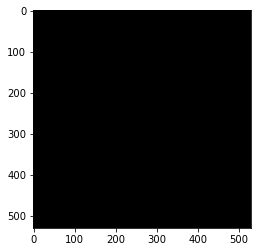

In [29]:
plot_gif(np.load("../22956814/A4_raw_2.npy"), '../22956814/gif/A4_raw_2.gif')
plot_gif(np.load("../22956814/A4_mask_2.npy"), '../22956814/gif/A4_mask_2.gif')
# looks good

In [30]:
import psutil
psutil.virtual_memory()  # looks good!

svmem(total=439595151360, available=425427021824, percent=3.2, used=10498428928, free=383010590720, active=20338724864, inactive=34078556160, buffers=63614976, cached=46022516736, shared=9056256, slab=1572651008)

In [ ]:
# Do the same for the rest of the wells:

wells = ['B1', 'B2', 'B3', 'B4']
well_cuts = [b1, b2, b3, b4]

for i, well in enumerate(wells):
    filename = '../22956814/raw_wells/%s.npy' % well
    get_raw_well(well=well_cuts[i], well_name=well, filename=filename)
    print(filename)

In [33]:
# Do alphabets, otherwise disk full.......

make_raw_videos(raw_video_path='../22956814/raw_wells/B1.npy', mask_frame_info_fn="../22956814/B1_not_empty.txt", well_name='B1')
make_raw_videos(raw_video_path='../22956814/raw_wells/B2.npy', mask_frame_info_fn="../22956814/B2_not_empty.txt", well_name='B2')
make_raw_videos(raw_video_path='../22956814/raw_wells/B3.npy', mask_frame_info_fn="../22956814/B3_not_empty.txt", well_name='B3')
make_raw_videos(raw_video_path='../22956814/raw_wells/B4.npy', mask_frame_info_fn="../22956814/B4_not_empty.txt", well_name='B4')

(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)


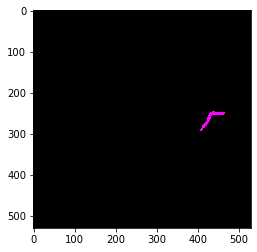

In [34]:
# Check gif! 

plot_gif(np.load("../22956814/B3_raw_2.npy"), '../22956814/gif/B3_raw_2.gif')
plot_gif(np.load("../22956814/B3_mask_2.npy"), '../22956814/gif/B3_mask_2.gif')

# looks good! 
# Then removes well B raw npys 

# Well Cs

In [6]:
wells = ['C1', 'C2', 'C3', 'C4', 'D1', 'D2', 'D3', 'D4']
well_cuts = [c1, c2, c3, c4, d1, d2, d3, d4]

for i, well in enumerate(wells):
    filename = '../22956814/raw_wells/%s.npy' % well
    get_raw_well(well=well_cuts[i], well_name=well, filename=filename)
    print(filename)

-------- C1 --------
../22956814/raw_wells/C1.npy
-------- C2 --------
../22956814/raw_wells/C2.npy
-------- C3 --------
../22956814/raw_wells/C3.npy
-------- C4 --------
../22956814/raw_wells/C4.npy
-------- D1 --------
../22956814/raw_wells/D1.npy
-------- D2 --------
../22956814/raw_wells/D2.npy
-------- D3 --------
../22956814/raw_wells/D3.npy
-------- D4 --------
../22956814/raw_wells/D4.npy


In [9]:
make_raw_videos(raw_video_path='../22956814/raw_wells/C1.npy', mask_frame_info_fn="../22956814/C1_not_empty.txt", well_name='C1')
make_raw_videos(raw_video_path='../22956814/raw_wells/C2.npy', mask_frame_info_fn="../22956814/C2_not_empty.txt", well_name='C2')
make_raw_videos(raw_video_path='../22956814/raw_wells/C3.npy', mask_frame_info_fn="../22956814/C3_not_empty.txt", well_name='C3')
make_raw_videos(raw_video_path='../22956814/raw_wells/C4.npy', mask_frame_info_fn="../22956814/C4_not_empty.txt", well_name='C4')

make_raw_videos(raw_video_path='../22956814/raw_wells/D1.npy', mask_frame_info_fn="../22956814/D1_not_empty.txt", well_name='D1')
make_raw_videos(raw_video_path='../22956814/raw_wells/D2.npy', mask_frame_info_fn="../22956814/D2_not_empty.txt", well_name='D2')
make_raw_videos(raw_video_path='../22956814/raw_wells/D3.npy', mask_frame_info_fn="../22956814/D3_not_empty.txt", well_name='D3')
make_raw_videos(raw_video_path='../22956814/raw_wells/D4.npy', mask_frame_info_fn="../22956814/D4_not_empty.txt", well_name='D4')

(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 530, 1)
(100, 530, 5